In [2]:
%load_ext autoreload

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [4]:
!nvidia-smi
# DEBUG
import pynvml
from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total / (1024**3)} Gb')
print(f'free     : {info.free / (1024**3)} Gb')
print(f'used     : {info.used / (1024**3)} Gb')

Sun Aug 30 02:21:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070    Off  | 00000000:1D:00.0  On |                  N/A |
|  0%   47C    P5    15W / 180W |   1373MiB /  8116MiB |      3%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [1]:
%load_ext autoreload
%autoreload
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from sys import exit
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

from datasets.kitti_raw_monosf import KITTI_Raw_KittiSplit_Train, KITTI_Raw_KittiSplit_Valid, CarlaDataset
from models.CNet import CNet
from augmentations import Augmentation_SceneFlow

# from losses import _adaptive_disocc_detection
from loss_consistency import Loss_SceneFlow_SelfSup_Consistency

args = {
    'batch_size' : 1,
    'num_workers' : 2,
    'epochs': 1, 
    'lr': 2e-4,
    'momentum': 0.9,
    'beta': 0.999,
    'weight_decay': 0.0,
    'train': True,
    'cuda': True,
    'debug': False,
    'evaluation': False,
    'finetuning': False,
}

data_root = '/external/datasets/kitti_data_jpg/'
# train_dataset = CarlaDataset({'baseline': 0.075}, data_root='/external/datasets/carla_stereo/Town01/')
train_dataset = KITTI_Raw_KittiSplit_Train(args={}, root=data_root, num_examples=1)


# train_loader = DataLoader(train_dataset, batch_size=args['batch_size'], num_workers=args['num_workers'], shuffle=True, pin_memory=True)
# val_dataset = KITTI_Raw_KittiSplit_Valid(args={}, root=data_root)
# val_loader = DataLoader(val_dataset, batch_size=args['batch_size'], num_workers=args['num_workers'], shuffle=False, pin_memory=True)

# augmentation = Augmentation_SceneFlow(args)
# model = CNet(args)
# model.train()

# loss = Loss_SceneFlow_SelfSup_Consistency(args)

# if args['cuda']:
#     augmentation = augmentation.cuda()
#     model = model.cuda()
    
# num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# # optimizer = Adam(model.parameters(), lr=args['lr'], betas=[args['momentum'], args['beta']], weight_decay=args['weight_decay'])

# start = time.time()
# model.train()
# for i, data in enumerate(train_loader):
    
#     input_keys = list(filter(lambda x: "input" in x, data.keys()))
#     target_keys = list(filter(lambda x: "target" in x, data.keys()))
#     tensor_keys = input_keys + target_keys

#     # Possibly transfer to Cuda
#     if args['cuda']:
#         for key, value in data.items():
#             if key in tensor_keys:
#                 data[key] = value.cuda(non_blocking=True)
    
#     with torch.no_grad():
#         data = augmentation(data)
        
#     out = model(data)
    
#     loss = loss(out, data)

#     if i == 0:
#         print((time.time() - start) / (i+1))
#         break

In [7]:
train_dataset = KITTI_Raw_KittiSplit_Train(args={}, root=data_root, num_examples=1)


In [23]:
T = train_dataset[0]['input_cam_r2l']
flip_mat = np.eye(3)
flip_mat[0, 0] = -1
print(flip_mat.dot(T))

[[-0.9995569  -0.02232752  0.01968681 -0.53268892]
 [ 0.02232752  0.99975014 -0.001062    0.00529762]
 [-0.01968681  0.00150172  0.99980509 -0.00149519]]


In [ ]:
fig = plt.figure(figsize=(16, 16))
r, c = 6, 2
for i, (k, v) in enumerate(data.items()):
    if type(v) == float or type(v) == int or type(v) == str: 
        print(k, v)
        continue
    elif len(v.shape) == 3:
        fig.add_subplot(r, c, i+1)
        cmap = None
        img = v.permute(1, 2, 0)
        if img.shape[-1] == 1:
            img = img.squeeze()
            cmap = 'gray'
        plt.imshow(img, cmap=cmap)
    else:
        print(f"{k}: {v}")

In [33]:
def pretty_size(size):
	"""Pretty prints a torch.Size object"""
	assert(isinstance(size, torch.Size))
	return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
	"""Prints a list of the Tensors being tracked by the garbage collector."""
	import gc
	total_size = 0
	for obj in gc.get_objects():
		try:
			if torch.is_tensor(obj):
				if not gpu_only or obj.is_cuda:
					print("%s:%s%s %s" % (type(obj).__name__, 
										  " GPU" if obj.is_cuda else "",
										  " pinned" if obj.is_pinned else "",
										  pretty_size(obj.size())))
					total_size += obj.numel()
			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
				if not gpu_only or obj.is_cuda:
					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__,
												   type(obj.data).__name__,
												   " GPU" if obj.is_cuda else "",
												   " pinned" if obj.data.is_pinned else "",
												   " grad" if obj.requires_grad else "", 
												   " volatile" if obj.volatile else "",
												   pretty_size(obj.data.size())))
					total_size += obj.data.numel()
		except Exception as e:
			pass        
	print("Total size:", total_size)

dump_tensors()

Parameter: GPU pinned 32 × 3 × 3 × 3
Parameter: GPU pinned 32
Parameter: GPU pinned 32 × 32 × 3 × 3
Parameter: GPU pinned 32
Parameter: GPU pinned 64 × 32 × 3 × 3
Parameter: GPU pinned 64
Parameter: GPU pinned 64 × 64 × 3 × 3
Parameter: GPU pinned 64
Parameter: GPU pinned 3 × 32 × 3 × 3
Parameter: GPU pinned 3
Parameter: GPU pinned 1 × 32 × 3 × 3
Parameter: GPU pinned 1
Parameter: GPU pinned 128 × 96 × 3 × 3
Parameter: GPU pinned 128
Parameter: GPU pinned 128 × 128 × 3 × 3
Parameter: GPU pinned 128
Parameter: GPU pinned 192 × 128 × 3 × 3
Parameter: GPU pinned 192
Parameter: GPU pinned 192 × 192 × 3 × 3
Parameter: GPU pinned 192
Parameter: GPU pinned 256 × 192 × 3 × 3
Parameter: GPU pinned 256
Parameter: GPU pinned 256 × 256 × 3 × 3
Parameter: GPU pinned 256
Parameter: GPU pinned 128 × 337 × 3 × 3
Parameter: GPU pinned 128
Parameter: GPU pinned 128 × 128 × 3 × 3
Parameter: GPU pinned 128
Parameter: GPU pinned 96 × 128 × 3 × 3
Parameter: GPU pinned 96
Parameter: GPU pinned 64 × 96 × 3 × 

/home/sniradi/envs/env_sf/lib/python3.7/site-packages/torch/distributed/distributed_c10d.py:100: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


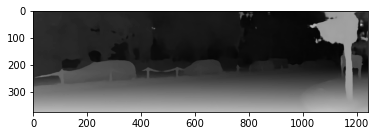

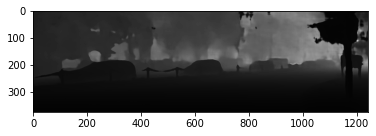

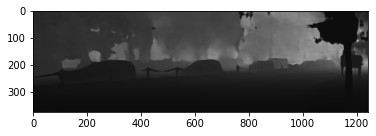

In [29]:
%autoreload
from losses import _disp2depth_kitti_K, _apply_disparity

disp = torch.tensor(plt.imread('../PSMNet/Test_disparity.png') / 255.)
plt.imshow(disp, cmap='gray')
plt.show()
depth_img = _disp2depth_kitti_K(disp, torch.tensor([721.5377])).squeeze()
depth_img_r = _apply_disparity(depth_img.unsqueeze(0).unsqueeze(0), disp.unsqueeze(0).unsqueeze(0))
plt.imshow(depth_img, cmap='gray')
plt.show()
plt.imshow(depth_img_r.squeeze(), cmap='gray')
plt.show()

In [12]:
%autoreload
import torch
from utils.sceneflow_util import cm_horizontal_flip
from utils.inverse_warp import pose2flow, pose_vec2mat
import numpy as np

pose = torch.tensor([[0.3, 0.4, 0.5, 0.1, 0.1, 0.1]], requires_grad=False)
pose_flipped = torch.tensor([[0.3, 0.4, 0.5, 0.1, 0.1, 0.1]], requires_grad=False)
pose_flipped = cm_horizontal_flip(pose_flipped)
pose_vec2mat(pose), pose_vec2mat(pose_flipped)
# print(pose_vec2mat(pose))

# pose[:, 0] *= -1
# pose_mat = pose_vec2mat(pose)
# print(pose_mat)

# pose_mat[:, 0, :-1] = pose_mat[:, :, :-1].T[0, :, :].T
# print(pose_mat)

(tensor([[[ 0.9900, -0.0993,  0.0998,  0.3000],
          [ 0.1093,  0.9890, -0.0993,  0.4000],
          [-0.0889,  0.1093,  0.9900,  0.5000]]]),
 tensor([[[-0.9900, -0.0993,  0.0998, -0.3000],
          [ 0.0894, -0.9910, -0.0993,  0.4000],
          [ 0.1088, -0.0894,  0.9900, -0.5000]]]))

In [5]:
import numpy as np

tmp = np.array([0,1])
ref_exp_mask = np.tile(tmp, 
                       (1,
                        1920 // 2,
                        1080 // 2,
                        1))

array([0, 1])

In [6]:
import torch
from models.CNet import CNet

state_dict = torch.load('/external/cnet/checkpoints/test/3.ckpt')

model = CNet({})
model.load_state_dict(state_dict['model_state_dict'])

<All keys matched successfully>

OrderedDict([('leakyRELU', LeakyReLU(negative_slope=0.1, inplace=True)),
             ('feature_pyramid_extractor',
              FeatureExtractor(
                (convs): ModuleList(
                  (0): Sequential(
                    (0): Sequential(
                      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
                      (1): LeakyReLU(negative_slope=0.1, inplace=True)
                    )
                    (1): Sequential(
                      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                      (1): LeakyReLU(negative_slope=0.1, inplace=True)
                    )
                  )
                  (1): Sequential(
                    (0): Sequential(
                      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
                      (1): LeakyReLU(negative_slope=0.1, inplace=True)
                    )
                    (1): Sequential(
                    